# Good Film // Bad Film
## Film Plot Synopses and etc. as Predictors of Critical Reception

This notebook builds a classifier which predicts whether or not a film will be "good" or "bad" based on the plot synopsis, the popularity of the leading actors, and other variables such as genre. "Good" films are those which perform better than the mean of all of the IMdB critic's rating scores in the dataset, while "bad" films score lower than that mean.

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', color_codes=True)

import nltk
from nltk import FreqDist, word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import enchant
english_d = enchant.Dict("en_US")
import re
import gensim
from gensim import corpora, models, similarities
import pickle

import pyLDAvis
import pyLDAvis.gensim

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

import xgboost as xgb
from xgboost import XGBClassifier
from patsy import dmatrices

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  defaults=argspec[3])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/statsmodels/base/wrapper.py:100: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use

## Get the data

In [2]:
imdb = pd.read_csv('imdb_5000_movies.csv') # Just a big Kaggle dataset full of movies.

One really nice thing about this dataset is that it provides the unique IMdB movie ID's, which we can pass to another API in order to supplement our data with more features. A key to the OMdB API cost a minimum of one dollar. Here we parse out those IMdB ID's:

In [73]:
imdb.shape

(5043, 28)

In [3]:
imdb_ids = [imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0] for i in range(len(imdb))]

Here we make the API calls, and persist our data to little .txt files:

In [4]:
# for id in imdb_ids:

#     request = requests.get(f'http://www.omdbapi.com/?i={id}&plot=full&apikey={API_KEY}').json()
#     text = str(request)  
    
#     f = open(f'movie_{id}', 'w+')
#     f.write(text)
#     f.close()

This is what we want our eventual pandas dataFrame to look like:

In [5]:
df = pd.DataFrame(columns=['Title', 'Year', 'ID', 'Plot', 'Genre', 'Production', 
                           'Director', 'Actor_1_name', 'Actor_1_fb_likes', 'Actor_2_name', 
                           'Actor_2_fb_likes', 'Actor_3_name', 'Actor_3_fb_likes', 'Budget', 
                           'Rated', 'Language', 'imdbRating'])

This is where we frankenstein together the kaggle dataset with what we got from OMdB:

In [6]:
for i in range(len(imdb_ids)):
    id = imdb.iloc[i]['movie_imdb_link'].split('title/')[1].split('/?')[0]
    x_file = open(os.path.join('Movies', f"movie_{id}"), "r") # Open up each movie's text file
    movie_text = x_file.readlines()[0]
    dict = eval(movie_text) # Coerce string to dictionary
    dict['Plot'] = dict['Plot'].replace("\'", "'") # Cleanup
    df = df.append({'Title': dict['Title'], 'Year': dict['Year'], 'ID': id, 
                    'Plot': dict['Plot'], 'Genre': dict['Genre'], 
                    'imdbRating': dict['imdbRating'], 
                    'Director': imdb.iloc[i,:].loc['director_name'], 
                    'Actor_1_name':imdb.iloc[i,:].loc['actor_1_name'], 
                    'Actor_1_fb_likes':imdb.iloc[i,:].loc['actor_1_facebook_likes'], 
                    'Actor_2_name':imdb.iloc[i,:].loc['actor_2_name'], 
                    'Actor_2_fb_likes':imdb.iloc[i,:].loc['actor_2_facebook_likes'], 
                    'Actor_3_name':imdb.iloc[i,:].loc['actor_3_name'], 
                    'Actor_3_fb_likes':imdb.iloc[i,:].loc['actor_3_facebook_likes'], 
                    'Budget':imdb.iloc[i,:].loc['budget'], 'Language':dict['Language'], 
                    'Rated':dict['Rated']}, ignore_index=True) # Add to dataframe

Here's our beautiful new dataFrame:

In [7]:
df.iloc[:3,:]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,Actor_2_fb_likes,Actor_3_name,Actor_3_fb_likes,Budget,Rated,Language,imdbRating
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,237000000.0,PG-13,"English, Spanish",7.8
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,300000000.0,PG-13,English,7.1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,393.0,Stephanie Sigman,161.0,245000000.0,PG-13,"English, Spanish, Italian, German, French",6.8


## Munging and EDA

We drop datapoints with null 'imdbRating' values, since that is our independent / target variable. We also convert these into binary; we are only concerned with whether or not a film's 'imbdRating' is above the mean (1) or below the mean (0). This binary value is saved into a new column called 'binary_target'.

Null values in the 'actor facebook likes' column were imputed from the column mean.

In [8]:
df = df[~((df['Plot'] == 'N/A')|(df['imdbRating'] == 'N/A'))] # Drops movies with null plots
df.imdbRating = df.imdbRating.astype(float)
df['binary_target'] = df['imdbRating'] >= df['imdbRating'].mean()   #binary target column. True = above mean ; False = below mean
df['binary_target'] = df['binary_target'].astype(int)
df['Actor_1_fb_likes'].fillna((df['Actor_1_fb_likes'].mean()), inplace=True)
df['Actor_2_fb_likes'].fillna((df['Actor_2_fb_likes'].mean()), inplace=True)
df['Actor_3_fb_likes'].fillna((df['Actor_3_fb_likes'].mean()), inplace=True)

In [9]:
df = df.reset_index()
df = df.drop(['index'], axis=1)
df[:3]

,Title,Year,ID,Plot,Genre,Production,Director,Actor_1_name,Actor_1_fb_likes,Actor_2_name,Actor_2_fb_likes,Actor_3_name,Actor_3_fb_likes,Budget,Rated,Language,imdbRating,binary_target
0,Avatar,2009,tt0499549,"When his brother is killed in a robbery, parap...","Action, Adventure, Fantasy, Sci-Fi",NaN,James Cameron,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,237000000.0,PG-13,"English, Spanish",7.8,1
1,Pirates of the Caribbean: At World's End,2007,tt0449088,"After Elizabeth, Will, and Captain Barbossa re...","Action, Adventure, Fantasy",NaN,Gore Verbinski,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,300000000.0,PG-13,English,7.1,1
2,Spectre,2015,tt2379713,A cryptic message from the past sends James Bo...,"Action, Adventure, Thriller",NaN,Sam Mendes,Christoph Waltz,11000.0,Rory Kinnear,393.0,Stephanie Sigman,161.0,245000000.0,PG-13,"English, Spanish, Italian, German, French",6.8,1


### One-hot encoding Genres

In [10]:
final_genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Sport', 'Thriller', 'War', 'Western']    

#create a list of lists, where each element is a list of a movie's classified genres
li = []
[li.append(df.iloc[i]['Genre'].split(', ')) for i in range(len(df))]

#adding columns to df for each genre, 1 represents the movie is classified under that genre, 0 is that it is not
for genre in final_genres:
    list = []
    [list.append(1) if genre in movie
    else list.append(0) for movie in li]
    df[genre] = list

### Creating a fresh DataFrame with everything but Plot Text Features

In [11]:
main_df = pd.DataFrame()

#join the features we want to narrow in on with our target variable
genres = df.iloc[:,-21:]
main_df['Year'] = [int(year.split('–')[0]) for year in df['Year'].values]
main_df = main_df.join(genres)

main_df[:3]

,Year,binary_target,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Musical,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western
0,2009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2007,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Log Transforming "Actor Facebook Likes"

'Actor_1_fb_likes' had some striking outliers and needed a log transform:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


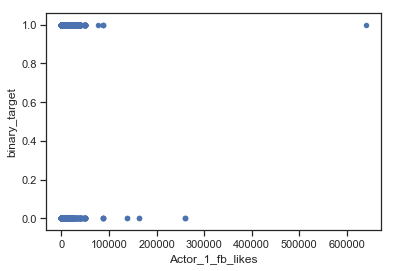

In [12]:
df.plot.scatter(x='Actor_1_fb_likes',
                    y='binary_target')

In [13]:
def log_transform_col(feature, dataframe):
    logged = pd.Series(np.log(dataframe[feature].values+1), name=feature+'_logged')
    return logged

actor_features = ['Actor_1_fb_likes', 'Actor_2_fb_likes','Actor_3_fb_likes']

actor_likes = [log_transform_col(actor_features[i], df) for i in range(len(actor_features))]

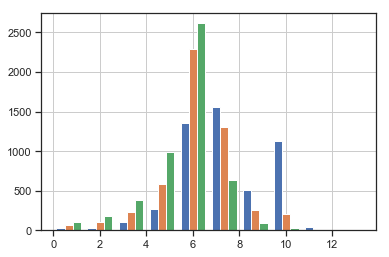

In [14]:
pd.Series(actor_likes).hist()

Looks way more gaussian after a log transform. We add these logged features to our dataframe:

In [15]:
main_df = main_df.join(actor_likes)
main_df[:3]

,Year,binary_target,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Mystery,Romance,Sci_Fi,Sport,Thriller,War,Western,Actor_1_fb_likes_logged,Actor_2_fb_likes_logged,Actor_3_fb_likes_logged
0,2009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6.908755,6.842683,6.752270
1,2007,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10.596660,8.517393,6.908755
2,2015,1,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,9.305741,5.976351,5.087596


### Baseline Logistic Regression without Plot-Text Features

Now that we've cleaned up a bit, we'll start throwing our features at a statsmodels logistic regression estimator to evaluate r^2 and p-values of various features.

In [16]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.589224
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4005
Method:                           MLE   Df Model:                           23
Date:                Mon, 25 Feb 2019   Pseudo R-squ.:                  0.1465
Time:                        10:04:14   Log-Likelihood:                -2374.0
converged:                       True   LL-Null:                       -2781.4
                                        LLR p-value:                2.437e-157
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  82.3166      6.980     11.794      0.000      68.637   

0.6974206349206349

This gives us an idea of which features might be less important in the determination of what makes a movie "good". We'll drop the less pertinent features and try again:

In [17]:
s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance) + C(Sci_Fi)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

Optimization terminated successfully.
         Current function value: 0.588716
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          binary_target   No. Observations:                 4029
Model:                          Logit   Df Residuals:                     4013
Method:                           MLE   Df Model:                           15
Date:                Mon, 25 Feb 2019   Pseudo R-squ.:                  0.1468
Time:                        10:04:14   Log-Likelihood:                -2371.9
converged:                       True   LL-Null:                       -2779.9
                                        LLR p-value:                3.402e-164
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  87.8001      6.935     12.660      0.000      74.207   

0.7043650793650794

In [18]:
main_df.columns

Index(['Year', 'binary_target', 'Action', 'Animation', 'Biography', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Horror', 'Mystery', 'Romance',
       'Sci_Fi', 'Thriller', 'Actor_1_fb_likes_logged',
       'Actor_2_fb_likes_logged', 'Actor_3_fb_likes_logged'],
      dtype='object')

These are the features we're sticking with for now.

### Correlation Matrices

We'd be remiss not to check for overly correlated features:

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserW

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(boundaries_list[j])


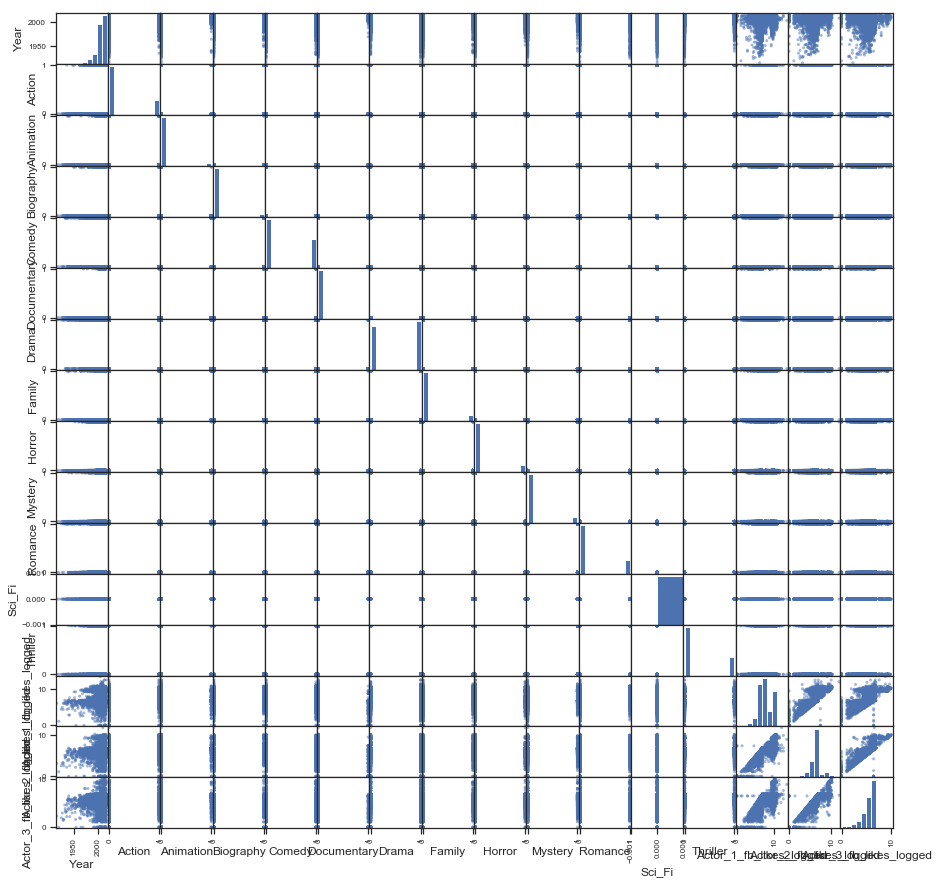

In [19]:
# Creating a multi-scatter plot
main_corr= main_df.drop(['binary_target'], axis=1).iloc[:,:]
pd.plotting.scatter_matrix(main_corr, figsize=[15,15]);

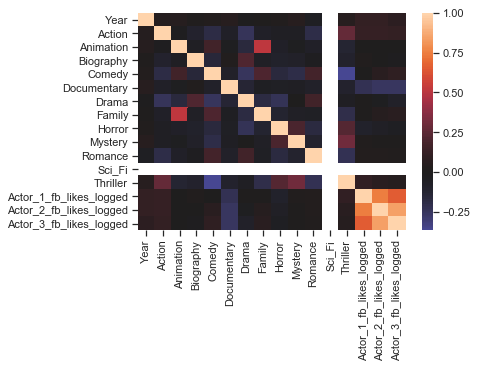

In [20]:
sns.heatmap(main_corr.corr(), center=0);

It's fairly intuitive that the social media popularity of the leading actors would be positively correlated, but we'll leave it in in case there are deviations from that norm. It's interesting to note that films in the "animation" genre are so commonly also in the "family" genre. Makes sense too.

## Using NLP to get features from the Plot Synopses

#### Setting up Lemmatization / Normalization Functions:

In [21]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def lemmatize(plot_list):
    lemmatized_plots = []
    
    for plot in plot_list:
        tokenized_lower = word_tokenize(plot.lower()) # Make plot summary lowercase and lemmatize        
        tokenized_lower =[word for word in tokenized_lower if english_d.check(word)] # Make sure it's an english word
        dirty_lemma = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokenized_lower] # Lemmatize
        dirty_lemma_string = ' '.join(dirty_lemma)
        
        # Filter out words that don't match this regex pattern:
        reg = re.compile((r"([a-zA-Z]+(?:'[a-z]+)?)"))
        lemmatized_regex = [word_lem for word_lem in dirty_lemma if word_lem in reg.findall(dirty_lemma_string)]
        
        # Remove stop words
        lemmatized = [word_lem for word_lem in lemmatized_regex if not word_lem in stop_words]
        lemmatized_string = ' '.join(lemmatized)
        lemmatized_plots.append(lemmatized_string)
        
    return lemmatized_plots

In [22]:
def get_wordnet_pos(word):
    """Map POS tag to the first character that lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

### Run the Lemmatizer

In [23]:
all_plots = [plot for plot in df.loc[:,'Plot'].values] # Get all movie plots.
plots = lemmatize(all_plots) # Lemmatize.

### Vectorizing Plots

In [24]:
# Term frequency = Number of times a word appears in a document / number of words in document
# Inverse document frequency = log base e(number of documents / number of documents with word in it)
# tf:idf = tf * idf

tfidf = TfidfVectorizer()
response = tfidf.fit_transform(plots)
print(response.shape)

tfidf_df = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

(5037, 13807)


Now we have all plots lemmatized as "plots" and vectorized / weighted as "tfidf_df".

### Incorporating some LDA; Clustering Documents by Topic

Gensim clusters words that appear together frequently. The clusters can be interpreted as general topics, and each movie gets weights indicating the degree to which it belongs to each topic. These weights are then re-incorporated as features in our dataset.

In [25]:
all_words = [plot.split(' ') for plot in plots] # Just formatting our corpus how Gensim wants it

In [26]:
dictionary = corpora.Dictionary(all_words)
corpus = [dictionary.doc2bow(text) for text in all_words]
pickle.dump(corpus, open('pickles/corpus.pkl', 'wb'))
dictionary.save('pickles/dictionary.gensim')

In [27]:
NUM_TOPICS = 30 # This value was arbitrarily chosen.
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10) # Also arb
ldamodel.save('pickles/model5.gensim')

In [28]:
topics = ldamodel.print_topics(num_words=4)
topics # These are examples of some of the clusters created by Gensim.

[(10, '0.014*"eve" + 0.012*"filmmaker" + 0.011*"sheriff" + 0.009*"disturb"'),
 (24, '0.012*"take" + 0.011*"film" + 0.010*"story" + 0.008*"find"'),
 (17, '0.016*"one" + 0.012*"go" + 0.012*"friend" + 0.010*"bond"'),
 (20, '0.014*"get" + 0.011*"life" + 0.010*"turn" + 0.009*"family"'),
 (9, '0.017*"film" + 0.012*"jack" + 0.011*"one" + 0.011*"life"'),
 (8, '0.012*"name" + 0.011*"john" + 0.010*"child" + 0.009*"horse"'),
 (1, '0.012*"year" + 0.011*"war" + 0.011*"one" + 0.010*"family"'),
 (22, '0.014*"get" + 0.013*"life" + 0.012*"want" + 0.012*"find"'),
 (4, '0.019*"town" + 0.017*"story" + 0.015*"vampire" + 0.012*"find"'),
 (16, '0.009*"become" + 0.009*"living" + 0.008*"dream" + 0.008*"becomes"'),
 (28, '0.022*"school" + 0.019*"life" + 0.012*"student" + 0.012*"year"'),
 (13, '0.010*"world" + 0.009*"one" + 0.008*"evil" + 0.008*"must"'),
 (3, '0.018*"prince" + 0.012*"mark" + 0.011*"troy" + 0.011*"crown"'),
 (7, '0.014*"dance" + 0.013*"prison" + 0.011*"day" + 0.008*"story"'),
 (27, '0.016*"love" 

In [29]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
22     0.175987  0.029928       1        1  10.043698
28     0.170292  0.080874       2        1   9.050389
9      0.113311 -0.025373       3        1   5.965908
27     0.136443  0.041343       4        1   5.377773
13    -0.000651 -0.168057       5        1   5.173555
2      0.028479 -0.148804       6        1   4.878797
12    -0.020786 -0.156486       7        1   4.600914
21     0.146257  0.066626       8        1   4.422730
17     0.119413 -0.005308       9        1   4.058169
19     0.112557  0.032860      10        1   3.953231
1      0.027166 -0.075847      11        1   3.922269
15     0.033842 -0.070910      12        1   3.558531
23     0.082831  0.050127      13        1   3.232137
20     0.086668  0.021523      14        1   3.231537
0      0.054116  0.029517      15        1   3.052319
24    -0.004918 -0.093924      16        1   2.998957
7      0.021388  0.027554      17        1   2.708184
4      0.077678  0.073712      18        1   2.519890
26     0.061891 -0.005082      19        1   2.380809
5     -0.011717 -0.075388      20        1   2.356484
16    -0.035010 -0.001054      21        1   2.172290
8     -0.032259  0.094941      22        1   1.819175
6     -0.192339 -0.152838      23        1   1.532277
11    -0.058539  0.067785      24        1   1.265173
25    -0.169361  0.046768      25        1   1.179217
14    -0.186203 -0.039479      26        1   1.125947
10    -0.142746  0.090166      27        1   0.996636
3     -0.187683  0.055736      28        1   0.832251
29    -0.199160  0.067987      29        1   0.821798
18    -0.206945  0.141103      30        1   0.768949, topic_info=     Category         Freq        Term        Total  loglift  logprob
658   Default   541.000000        town   541.000000  30.0000  30.0000
359   Default   580.000000      school   580.000000  29.0000  29.0000
230   Default   393.000000         war   393.000000  28.0000  28.0000
3678  Default   175.000000       frank   175.000000  27.0000  27.0000
2124  Default   507.000000        film   507.000000  26.0000  26.0000
1149  Default  1057.000000      family  1057.000000  25.0000  25.0000
244   Default   827.000000      father   827.000000  24.0000  24.0000
34    Default   975.000000        love   975.000000  23.0000  23.0000
332   Default   243.000000       earth   243.000000  22.0000  22.0000
761   Default   763.000000       story   763.000000  21.0000  21.0000
212   Default  2033.000000        life  2033.000000  20.0000  20.0000
460   Default  1407.000000         get  1407.000000  19.0000  19.0000
544   Default   423.000000        team   423.000000  18.0000  18.0000
248   Default  1164.000000      friend  1164.000000  17.0000  17.0000
1327  Default   138.000000        band   138.000000  16.0000  16.0000
188   Default   342.000000      police   342.000000  15.0000  15.0000
1025  Default   556.000000         son   556.000000  14.0000  14.0000
2141  Default   300.000000     student   300.000000  13.0000  13.0000
313   Default   592.000000      mother   592.000000  12.0000  12.0000
227   Default   763.000000         try   763.000000  11.0000  11.0000
2707  Default   265.000000        drug   265.000000  10.0000  10.0000
68    Default   847.000000       world   847.000000   9.0000   9.0000
676   Default   261.000000       human   261.000000   8.0000   8.0000
207   Default   294.000000        john   294.000000   7.0000   7.0000
315   Default  1595.000000         one  1595.000000   6.0000   6.0000
101   Default   212.000000        jack   212.000000   5.0000   5.0000
152   Default  1206.000000         new  1206.000000   4.0000   4.0000
31    Default   529.000000        kill   529.000000   3.0000   3.0000
696   Default   543.000000        girl   543.000000   2.0000   2.0000
327   Default  1039.000000        year  1039.000000   1.0000   1.0000
...       ...          ...         ...          ...      ..

In [30]:
tm = pd.DataFrame()
for i in range(len(corpus)):
    new_row = np.zeros(NUM_TOPICS)
    for toop in ldamodel.get_document_topics(corpus[i]): # These two lines are where you do what you need to do
        new_row[toop[0]] = toop[1]                       # to flip zeroes to ones if the genre appears
    tm = tm.append(pd.Series(new_row), ignore_index=1)

In [31]:
tm.head() # This is a DataFrame with the weights from the GenSim clustering.

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.000000,0.065405,0.0,0.023721,0.0,0.159059,0.0,0.018701,0.000000,...,0.042917,0.056712,0.0,0.000000,0.000000,0.0,0.0,0.0,0.280801,0.000000
1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.078276,...,0.000000,0.000000,0.0,0.000000,0.170539,0.0,0.0,0.0,0.000000,0.000000
2,0.000000,0.000000,0.052448,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.017731
3,0.644623,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.174613,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.266416,0.501339,0.0,0.0,0.0,0.000000,0.000000


## Joining GenSim Results with Vectorized Plot Synopses

In [32]:
plots_and_topics = tfidf_df.join(tm)

In [33]:
plots_and_topics.head()

,aardvark,aback,abandon,abandonment,abate,abatement,abbey,abdicate,abduct,abduction,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042917,0.056712,0.0,0.000000,0.000000,0.0,0.0,0.0,0.280801,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.170539,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.017731
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.266416,0.501339,0.0,0.0,0.0,0.000000,0.000000


## Dimensionality Reduction with SVD - For the PlotText Data

In [34]:
svd = TruncatedSVD(n_components=14, n_iter=3, random_state=42)
plots_and_topics_pca = pd.DataFrame(svd.fit_transform(plots_and_topics))
print(svd.explained_variance_ratio_.sum())

0.16514497185991742


## Joining PlotText with the Other Features

In [35]:
df = main_df.join(plots_and_topics_pca)
len(df.columns)

31

## Advanced Models

In [36]:
X = df.drop(['binary_target'], axis=1)
y = df.binary_target
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


train_test_split on X_scaled:

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size =  0.2)

First we'll try a simple Gaussian Naive Bayes Model:

In [59]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
print(metrics.classification_report(y_test, y_preds))
test_accuracy = accuracy_score(y_test,y_preds)
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

              precision    recall  f1-score   support

           0       0.54      0.85      0.66       474
           1       0.73      0.37      0.49       534

   micro avg       0.59      0.59      0.59      1008
   macro avg       0.64      0.61      0.58      1008
weighted avg       0.64      0.59      0.57      1008

Test accuracy: 59.33%


Now we'll go nuts and try an XGBClassifier model:

In [60]:
clf = xgb.XGBClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Test accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 75.7%
Test accuracy: 69.94%


In [61]:
y_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.7641614911740072


AUC: 0.7641614911740072


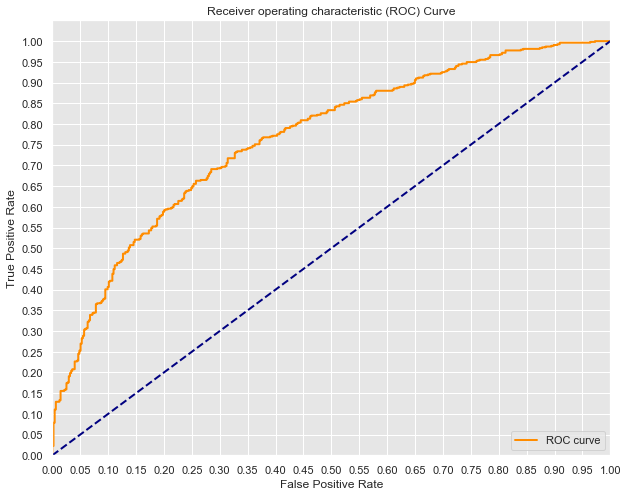

In [62]:
def draw_roc_curve(fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
draw_roc_curve(fpr,tpr)

Looks like we're off to a good start!

## Grid Searching for ideal dimensionality and classifier parameters

In [68]:
pipe = Pipeline([
    ('reduce_dim', TruncatedSVD()),
    ('classify', XGBClassifier())
])

score = {'f1': 'f1', 'accuracy': 'accuracy'}

N_FEATURES_OPTIONS = [3,7,14,20]

itera = [3, 5, 7]
n_est = [50,80,100,120,200]
# max_dep = [2,3,4,5]
# min_samp = [4,5,6,10]

param_grid = [
    {
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_iter': itera,
        'classify__n_estimators': n_est
#         'classify__max_depth': max_dep,
#         'classify__min_samples_split':min_samp
    }]

reducer_labels = ['TruncatedSVD']

grid_adc = GridSearchCV(pipe, n_jobs=-1, param_grid=param_grid, scoring=score, refit='accuracy')
grid_adc.fit(X_train, y_train)
grid_adc.best_params_

/Users/rob/.local/share/virtualenvs/Good-Film-Bad-Film-Rln20_LE/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'classify__n_estimators': 80,
 'reduce_dim': TruncatedSVD(algorithm='randomized', n_components=20, n_iter=3,
        random_state=None, tol=0.0),
 'reduce_dim__n_components': 20,
 'reduce_dim__n_iter': 3}

In [69]:
# Check the gridsearch results:
y_preds = grid_adc.predict(X_test)
accuracy_score(y_test, y_preds)

0.685515873015873

In [70]:
y_score = grid_adc.predict_proba(X_test)
fpr_gs, tpr_gs, thresholds = roc_curve(y_test, y_score[:,1])
print('AUC: {}'.format(auc(fpr_gs, tpr_gs)))

AUC: 0.7433903822753203


AUC: 0.7641614911740072


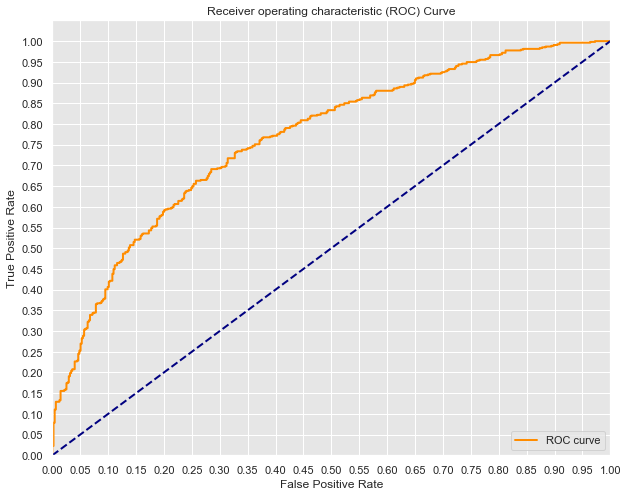

In [71]:
draw_roc_curve(fpr,tpr)

<Figure size 432x288 with 0 Axes>

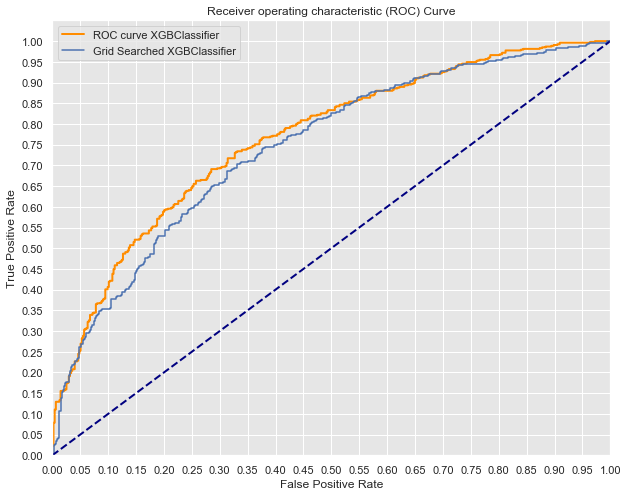

In [72]:
plt.figure(0).clf()

# pred = np.random.rand(1000)
# label = np.random.randint(2, size=1000)
# fpr, tpr, thresh = metrics.roc_curve(label, pred)
# auc = metrics.roc_auc_score(, pred)
# pred = np.random.rand(1000)
# label = np.random.randint(2, size=1000)
# fpr, tpr, thresh = metrics.roc_curve(label, pred)
# auc = metrics.roc_auc_score(label, pred)
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve XGBClassifier')
plt.plot(fpr_gs,tpr_gs,label='Grid Searched XGBClassifier')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.legend(loc=0)

Looks like it actually scored better before we tried to tune it